✅ GPU memory growth enabled
Total available pairs: 58620
Train samples: 16000, Val samples: 4000 (total chosen 20000)
Steps per epoch: 4000 Validation steps: 1000
Model: "Hybrid_UNet_ViT_CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 reshape (Reshape)              (None, 8, 16, 8, 16  0           ['input_image[0][0]']            
                                , 1)                                                              
                                                                                                  
 permute (Pe

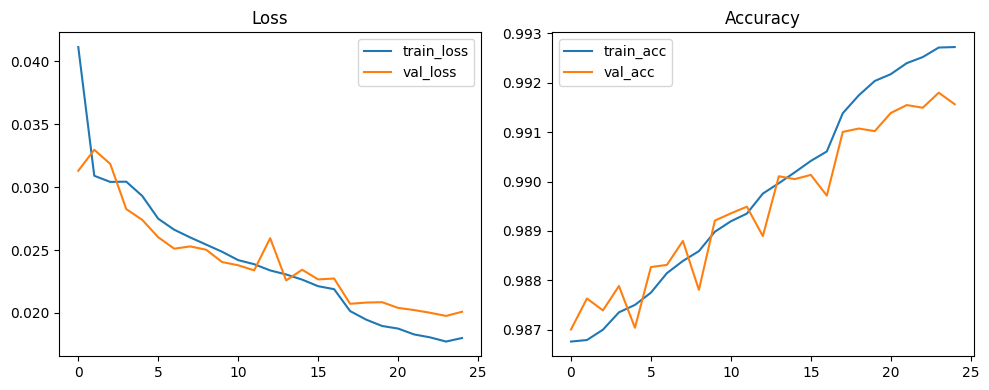


Showing 4 sample predictions from validation set...


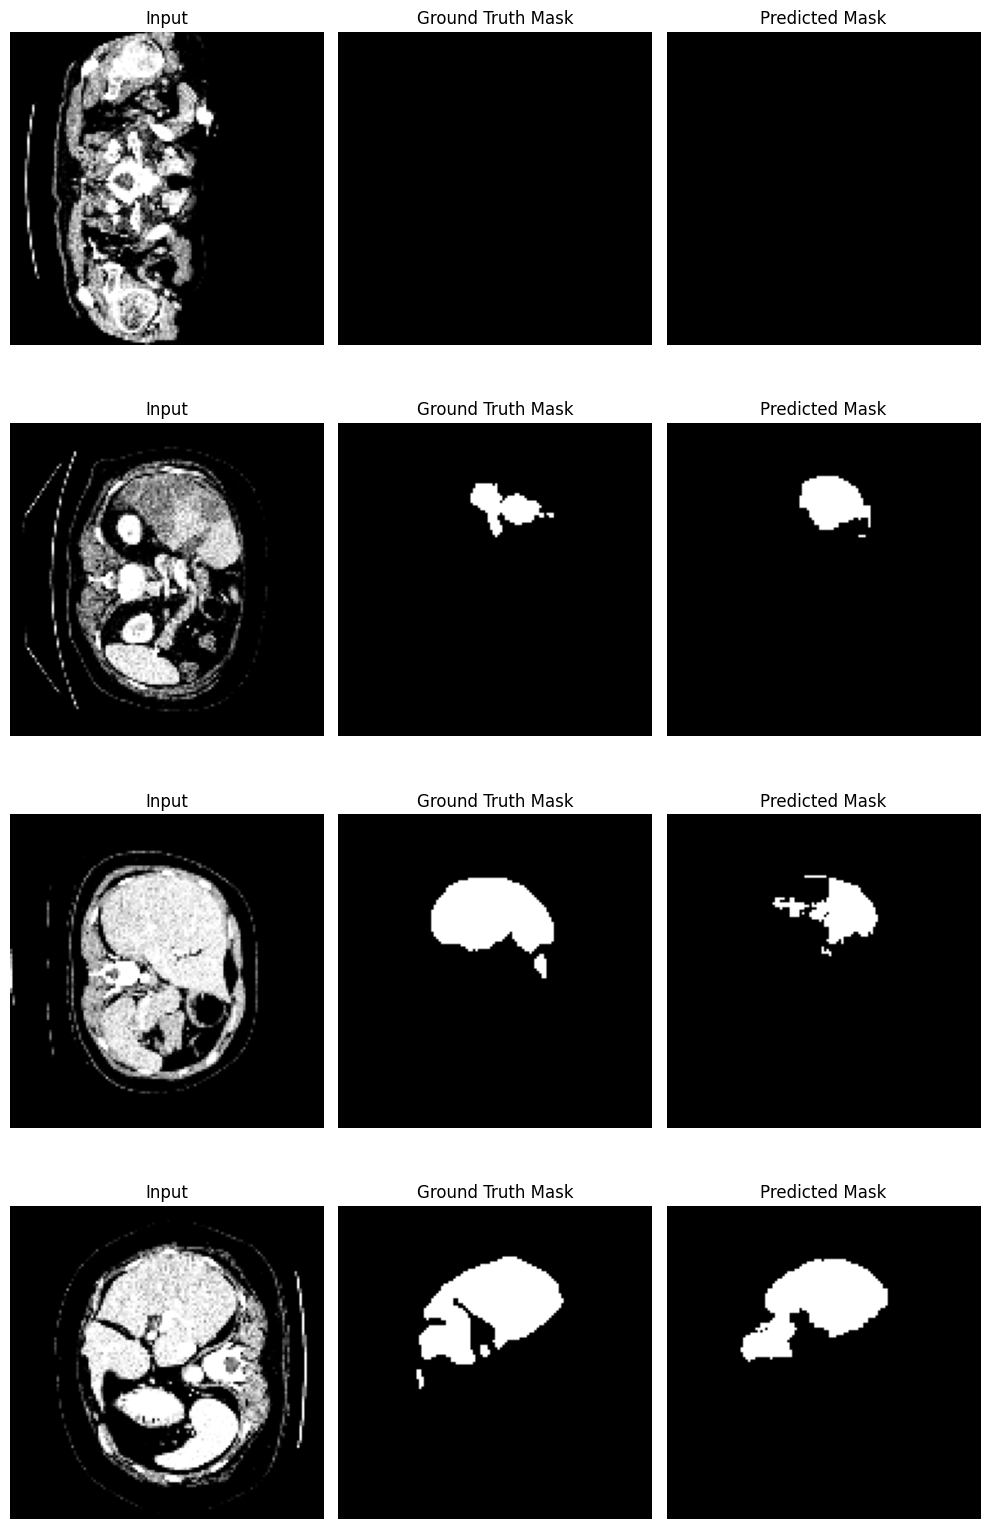


✅ Hybrid training & evaluation complete. Best checkpoint (if saved) at: best_hybrid_checkpoint.h5


In [ ]:
"""
hybrid_unet_vit_capsnet_20k_streaming.py

Hybrid segmentation model: UNet encoder + ViT encoder + Capsule-like encoder (conv)
Fusion at bottleneck (concatenate feature maps), then UNet-style decoder.

Streaming training on 20k random image-mask pairs (no full dataset in RAM).
Saves best checkpoint and computes metrics on validation set.

Adjust BATCH_SIZE, NUM_SAMPLES, EPOCHS to fit your GPU/RAM.
"""

import os
import random
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# ----------------------------
# Config
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMAGE_DIR = r"E:\CDownloads\LiverDataset\images"
MASK_DIR  = r"E:\CDownloads\LiverDataset\masks"
IMG_SIZE = (128, 128)        # input resolution
NUM_SAMPLES = 20000          # sample 20k pairs
BATCH_SIZE = 4               # reduce if OOM
EPOCHS = 25
CHECKPOINT_PATH = "best_hybrid_checkpoint.h5"
PRED_SAMPLES_TO_SHOW = 4

# ----------------------------
# GPU memory growth
# ----------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except Exception as e:
        print("⚠️ GPU memory growth setup failed:", e)
else:
    print("⚠️ No GPU found — training on CPU")

# ----------------------------
# Helpers: collect indices and train/val split
# ----------------------------
def collect_sample_indices(image_dir, mask_dir, num_samples):
    imgs = sorted([f for f in os.listdir(image_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    masks = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    total = min(len(imgs), len(masks))
    if total == 0:
        raise ValueError("No images/masks found in provided directories.")
    print(f"Total available pairs: {total}")
    chosen = random.sample(list(range(total)), min(num_samples, total))
    return imgs, masks, chosen

imgs_list, masks_list, chosen_indices = collect_sample_indices(IMAGE_DIR, MASK_DIR, NUM_SAMPLES)

# split
val_ratio = 0.2
random.shuffle(chosen_indices)
num_chosen = len(chosen_indices)
num_val = int(math.ceil(val_ratio * num_chosen))
train_indices = chosen_indices[:-num_val]
val_indices = chosen_indices[-num_val:]
print(f"Train samples: {len(train_indices)}, Val samples: {len(val_indices)} (total chosen {num_chosen})")

# ----------------------------
# Streaming generator (grayscale)
# ----------------------------
def preprocess_image(path, img_size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Can't read {path}")
    img = cv2.resize(img, img_size)
    img = img.astype(np.float32) / 255.0
    return np.expand_dims(img, axis=-1)

def mask_to_binary(mask_arr):
    return (mask_arr >= 0.5).astype(np.float32)

def batch_generator(image_dir, mask_dir, imgs_list, masks_list, index_list, batch_size, img_size, shuffle=True):
    n = len(index_list)
    while True:
        if shuffle:
            random.shuffle(index_list)
        for i in range(0, n, batch_size):
            batch_idx = index_list[i:i+batch_size]
            Xb, Yb = [], []
            for idx in batch_idx:
                img_path = os.path.join(image_dir, imgs_list[idx])
                mask_path = os.path.join(mask_dir, masks_list[idx])
                try:
                    img = preprocess_image(img_path, img_size)
                    mask = preprocess_image(mask_path, img_size)
                except Exception as e:
                    print("Skipping file due to error:", e)
                    continue
                Xb.append(img)
                Yb.append(mask_to_binary(mask))
            if len(Xb) == 0:
                continue
            Xb = np.stack(Xb, axis=0).astype(np.float32)
            Yb = np.stack(Yb, axis=0).astype(np.float32)
            yield Xb, Yb

train_gen = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, train_indices, BATCH_SIZE, IMG_SIZE, shuffle=True)
val_gen   = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)

steps_per_epoch = math.ceil(len(train_indices) / BATCH_SIZE)
validation_steps = math.ceil(len(val_indices) / BATCH_SIZE)
print("Steps per epoch:", steps_per_epoch, "Validation steps:", validation_steps)

# ----------------------------
# Model pieces
# ----------------------------
def unet_encoder_block(x_in):
    # return c1, c2, c3 (for skip connections) and bottleneck feature (c3)
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x_in)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)  # 64x64

    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)  # 32x32

    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)  # 16x16

    # bottleneck conv further
    b = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p3)  # 16x16x128
    b = layers.Dropout(0.3)(b)
    b = layers.Conv2D(128, (3,3), activation='relu', padding='same')(b)   # 16x16x128
    return c1, c2, c3, b

def vit_encoder_block(x_in, patch_size=16, embed_dim=128, num_heads=4, mlp_dim=256, num_layers=4, dropout_rate=0.1):
    H, W = IMG_SIZE
    C = 1
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    num_patches = num_patches_h * num_patches_w
    patch_area = patch_size * patch_size * C

    # create patches (batch, num_patches, patch_area)
    x = layers.Reshape((num_patches_h, patch_size, num_patches_w, patch_size, C))(x_in)
    x = layers.Permute((1,3,2,4,5))(x)
    x = layers.Reshape((num_patches, patch_area))(x)

    # linear projection
    x = layers.Dense(embed_dim)(x)  # (B, num_patches, embed_dim)

    # positional embeddings (learnable)
    pos = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)(tf.range(num_patches))
    x = x + pos

    # transformer encoder stack (small)
    for _ in range(num_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads, dropout=dropout_rate)(x1, x1)
        x = layers.Add()([x, attn])
        x2 = layers.LayerNormalization(epsilon=1e-6)(x)
        mlp = layers.Dense(mlp_dim, activation='gelu')(x2)
        mlp = layers.Dropout(dropout_rate)(mlp)
        mlp = layers.Dense(embed_dim)(mlp)
        mlp = layers.Dropout(dropout_rate)(mlp)
        x = layers.Add()([x, mlp])

    # project tokens back to spatial feature map of shape (16,16,64)
    decoder_filters = 64
    x = layers.Dense(patch_size * patch_size * decoder_filters)(x)  # (B, num_patches, patch_area * decoder_filters)
    x = layers.Reshape((num_patches_h, num_patches_w, patch_size, patch_size, decoder_filters))(x)
    x = layers.Permute((1,3,2,4,5))(x)
    x = layers.Reshape((H, W, decoder_filters))(x)

    # reduce to 16x16x64 by conv + pooling
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((8,8))(x)  # from 128 -> 16
    # result shape: (16,16,64)
    return x

def capsule_like_encoder_block(x_in):
    # capsule-ish feature extractor: convs -> reshape to vector per spatial location -> squash-like nonlinearity
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x_in)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    # reduce spatial resolution to 16x16
    x = layers.MaxPooling2D((8,8))(x)  # 128->16
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)  # 16x16x64
    # optional small "capsule" vector normalization per location
    # implement a simple l2-normalize per channel vector to mimic capsule length
    x = tf.keras.layers.Lambda(lambda t: tf.nn.l2_normalize(t, axis=-1))(x)
    return x

# ----------------------------
# Build hybrid model
# ----------------------------
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1), name="input_image")

# UNet encoder path (we'll keep skip connectors)
c1, c2, c3, b_unet = unet_encoder_block(inputs)   # b_unet: 16x16x128

# ViT encoder path (returns 16x16x64)
b_vit = vit_encoder_block(inputs, patch_size=16, embed_dim=128, num_heads=4, mlp_dim=256, num_layers=4, dropout_rate=0.1)

# Capsule-like encoder path (returns 16x16x64)
b_caps = capsule_like_encoder_block(inputs)

# Fuse bottleneck features: resize/unify channels if needed
# Ensure shapes: b_unet (16,16,128), b_vit (16,16,64), b_caps (16,16,64)
fused = layers.Concatenate(axis=-1)([b_unet, b_vit, b_caps])  # (16,16,256)

# optional conv to mix fused features
fused = layers.Conv2D(192, (3,3), activation='relu', padding='same')(fused)
fused = layers.Dropout(0.2)(fused)
fused = layers.Conv2D(128, (3,3), activation='relu', padding='same')(fused)  # final fused (16,16,128)

# Decoder: upsample to 32, concat with c3? c3 is 32x32? Wait: c3 earlier is 32x32? In our UNet encoder c3 was 32x32 before pooling to p3. We used p3->b_unet. So:
# c3 corresponds to output before p3: shape (32,32,64) — we can upsample fused to 32x32 and concat with c3.
u1 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(fused)  # 32x32x64
u1 = layers.Concatenate()([u1, c3])  # concat with UNet c3 (32x32x64) -> 32x32x128
u1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u1)
u1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u1)

# up to 64x64, concat with c2
u2 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(u1)  # 64x64x32
u2 = layers.Concatenate()([u2, c2])  # c2 is 64x64x32 -> concat -> 64x64x64
u2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u2)
u2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u2)

# up to 128x128, concat with c1
u3 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(u2)  # 128x128x16
u3 = layers.Concatenate()([u3, c1])  # c1 is 128x128x16 -> concat -> 128x128x32
u3 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(u3)
u3 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(u3)

outputs = layers.Conv2D(1, (1,1), activation='sigmoid', name='segmentation_mask')(u3)

model = models.Model(inputs=inputs, outputs=outputs, name='Hybrid_UNet_ViT_CapsNet')
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ----------------------------
# Callbacks
# ----------------------------
cb_checkpoint = callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', save_best_only=True, verbose=1)
cb_reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
cb_earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

# ----------------------------
# Train (generator-based)
# ----------------------------
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[cb_checkpoint, cb_reduce_lr, cb_earlystop],
    verbose=1
)

# ----------------------------
# Metric helpers: Dice & IoU
# ----------------------------
def dice_coef_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    inter = np.sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    inter = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

# ----------------------------
# Evaluate on validation set (streaming)
# ----------------------------
print("\n🔍 Running evaluation on validation set (streaming predictions)...")
y_trues = []
y_preds_probs = []

val_iter = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)
batches_done = 0
while batches_done < validation_steps:
    Xb, Yb = next(val_iter)
    preds = model.predict(Xb)  # (batch, H, W, 1)
    y_trues.append(Yb)
    y_preds_probs.append(preds)
    batches_done += 1

y_trues = np.concatenate(y_trues, axis=0)
y_preds_probs = np.concatenate(y_preds_probs, axis=0)
n_val = min(y_trues.shape[0], y_preds_probs.shape[0])
y_trues = y_trues[:n_val]
y_preds_probs = y_preds_probs[:n_val]

y_true_flat = (y_trues.flatten() > 0.5).astype(np.uint8)
y_pred_prob_flat = y_preds_probs.flatten()
y_pred_flat = (y_pred_prob_flat > 0.5).astype(np.uint8)

precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)
try:
    auc = roc_auc_score(y_true_flat, y_pred_prob_flat)
except ValueError:
    auc = float('nan')

dice_list = []
iou_list = []
for i in range(n_val):
    gt = (y_trues[i].squeeze() > 0.5).astype(np.float32)
    pr = (y_preds_probs[i].squeeze() > 0.5).astype(np.float32)
    dice_list.append(dice_coef_np(gt, pr))
    iou_list.append(iou_np(gt, pr))

mean_dice = float(np.mean(dice_list))
mean_iou = float(np.mean(iou_list))

print("\n📊 Validation Metrics (flattened):")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"AUC-ROC   : {auc if not math.isnan(auc) else 'N/A'}")
print(f"Mean Dice : {mean_dice:.4f}")
print(f"Mean IoU  : {mean_iou:.4f}")

# ----------------------------
# Plot training curves
# ----------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history.get('loss', []), label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.title('Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history.get('accuracy', []), label='train_acc')
plt.plot(history.history.get('val_accuracy', []), label='val_acc')
plt.title('Accuracy'); plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# Show sample predictions
# ----------------------------
print(f"\nShowing {PRED_SAMPLES_TO_SHOW} sample predictions from validation set...")
n_show = min(PRED_SAMPLES_TO_SHOW, n_val)
fig, axs = plt.subplots(n_show, 3, figsize=(10, 4*n_show))
for i in range(n_show):
    gt = y_trues[i].squeeze()
    prob = y_preds_probs[i].squeeze()
    pred_bin = (prob > 0.5).astype(np.uint8)

    idx_in_list = val_indices[i]
    input_img_path = os.path.join(IMAGE_DIR, imgs_list[idx_in_list])
    input_img = cv2.imread(input_img_path, cv2.IMREAD_GRAYSCALE)
    input_img = cv2.resize(input_img, IMG_SIZE) / 255.0

    axs[i,0].imshow(input_img, cmap='gray'); axs[i,0].set_title('Input')
    axs[i,1].imshow(gt, cmap='gray'); axs[i,1].set_title('Ground Truth Mask')
    axs[i,2].imshow(pred_bin, cmap='gray'); axs[i,2].set_title('Predicted Mask')
    for ax in axs[i]:
        ax.axis('off')
plt.tight_layout()
plt.show()

print("\n✅ Hybrid training & evaluation complete. Best checkpoint (if saved) at:", CHECKPOINT_PATH)
